In [3]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.interpolate as spi
import igrf12


In [4]:
# Load magnetometer data, merging if more than one source file
#df1 = pd.read_csv('/Users/simon/Work/ECOSAT3/Magnetometer/mag_20190825_0047_utc.csv',skiprows=6,na_values='*')
#df2 = pd.read_csv('/Users/simon/Work/ECOSAT3/Magnetometer/mag_20190901_0650_utc.csv',skiprows=6,na_values='*')
#df = pd.concat([df1,df2],ignore_index=True)

df = pd.read_csv('./Data/in2019_v04_mag.csv')

df = df.dropna(subset=['Mag_Longitude','Mag_Latitude'])

res = df['Reading_Date']+' '+df['Reading_Time']
df['timeindex'] = pd.to_datetime(res, format='%d-%b-%Y %H:%M:%S.%f')
df = df.set_index('timeindex')

df.columns

Index(['Unnamed: 0', 'Reading_Date', 'Reading_Time', 'Base_Station',
       'Magnetic_Field', 'Signal_Quality', 'Depth', 'Altitude', 'Leak',
       'Measurement_Time', 'Signal_Strength', 'Gradient_Condition',
       'Weak_Signal', 'Poor_Reading', 'Instrument_Mistuned', 'Reading_ID',
       'System_Date', 'System_Time', 'Line_Name', 'Marker', 'Marker_Date',
       'Marker_Time', 'Error', 'Mag_Latitude', 'Mag_Longitude', 'Mag_Easting',
       'Mag_Northing', 'Mag_Zone', 'Mag_Position_Change', 'GPS_Latitude',
       'GPS_Longitude', 'GPS_Easting', 'GPS_Northing', 'GPS_Zone',
       'GPS_Position_Change'],
      dtype='object')

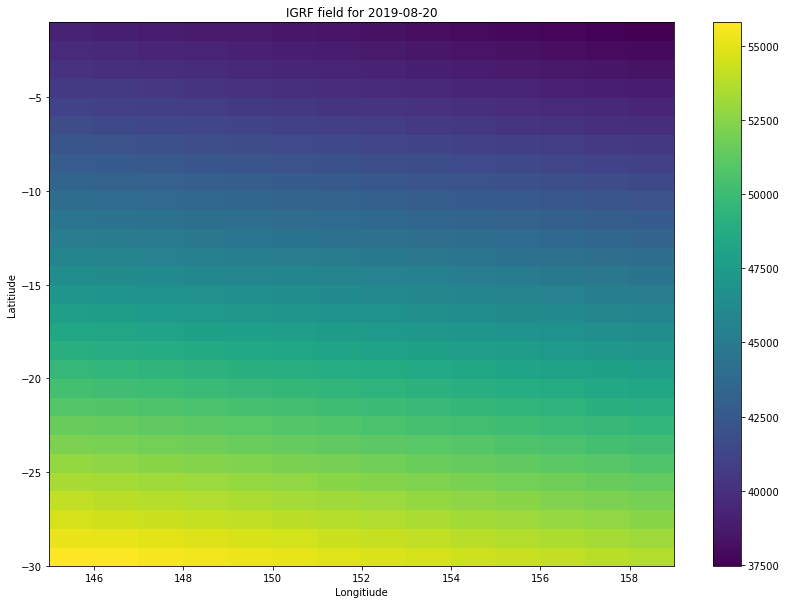

In [11]:
# This section deals with making an IGRF map for the study area, taken on a day mid-way through the voyage timespan
X = np.arange(145,160,1)
Y = np.arange(-30,0,1)
Xg,Yg = np.meshgrid(X,Y)

igrf = []
for Xp,Yp in zip(Xg.flatten(),Yg.flatten()):
    #print(Yp,Xp)
    mag = igrf12.igrf('2019-08-20', glat=Yp, glon=Xp, alt_km=0)
    igrf.append(mag.total.data)

igrf_grid = np.reshape(igrf,Xg.shape)

#print(mag)
#print(Xg.shape)
plt.figure(figsize=(14,10))
plt.pcolormesh(Xg,Yg,igrf_grid)
plt.colorbar()
plt.xlabel('Longitiude')
plt.ylabel('Latitiude')
plt.title('IGRF field for 2019-08-20')
plt.savefig('in2018_v04_igrf.png')
plt.show()

-46.860597806459076


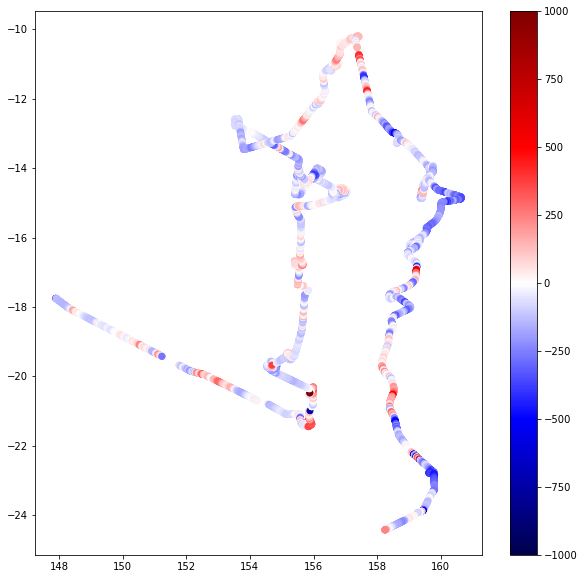

In [7]:
# Interpolate the IGRF field at each measurement point
f = spi.RectBivariateSpline(X,Y,igrf_grid.T)
tmp = f.ev(df.Mag_Longitude,df.Mag_Latitude)
igrf_at_points = tmp.flatten()

igrf_corrected_mag = df.Magnetic_Field-igrf_at_points

df['igrf'] = igrf_at_points
df['igrf_corrected_mag'] = df.Magnetic_Field-df.igrf   #igrf_corrected_mag


print(np.mean(igrf_corrected_mag))
              
plt.figure(figsize=(10,10))
plt.scatter(df.Mag_Longitude[::10],df.Mag_Latitude[::10],c=df.igrf_corrected_mag[::10],
            vmin=-1000,vmax=1000,cmap=plt.cm.seismic)
plt.colorbar()



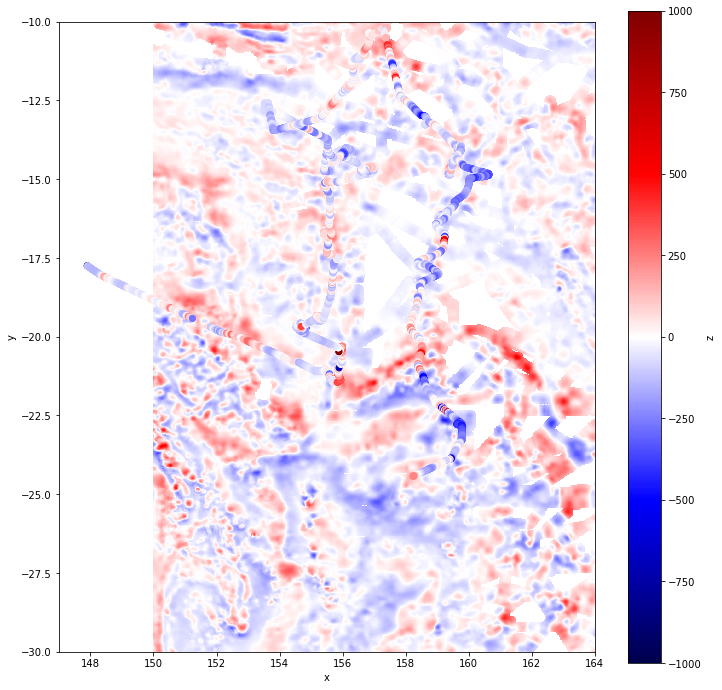

In [9]:
ds = xr.open_dataset('/Users/simon/Work/ECOSAT/MagneticGrids/emag2_ECOSAT.nc')

plt.figure(figsize=(12,12))
ds['z'].plot(vmin=-1000,vmax=1000,cmap=plt.cm.seismic)
plt.scatter(df.Mag_Longitude[::10],df.Mag_Latitude[::10],c=df.igrf_corrected_mag[::10],
            vmin=-1000,vmax=1000,cmap=plt.cm.seismic)
plt.xlim(147,164)
plt.ylim(-30,-10)
plt.gca().set_aspect('equal')

In [13]:
# Load the base station files and merge into a single dataframe
dfb1 = pd.read_csv('./Data/CTA1908060000TO1908162359.txt',skiprows=1)
dfb2 = pd.read_csv('./Data/CTA1908170000TO1908272359.txt',skiprows=1)
dfb3 = pd.read_csv('./Data/CTA1908280000TO1908312359.txt',skiprows=1)
dfb4 = pd.read_csv('./Data/CTA1909010000TO1909052359.txt',skiprows=1)

df_base_station = pd.concat([dfb1,dfb2,dfb3,dfb4],ignore_index=True)

df_base_station

,yyyy-MM-dd HH:mm:ss,X (nT),Y (nT),Z (nT),H (nT),F (nT),D (Degrees),I (Degrees)
0,2019-08-06 00:00:00,31408.1,4026.9,-37501.9,31665.2,49082.4,7.306,-49.823
1,2019-08-06 00:01:00,31408.3,4026.8,-37501.9,31665.4,49082.5,7.306,-49.823
2,2019-08-06 00:02:00,31408.8,4026.8,-37502.0,31665.8,49082.8,7.306,-49.823
3,2019-08-06 00:03:00,31409.1,4026.6,-37502.0,31666.2,49083.1,7.305,-49.823
4,2019-08-06 00:04:00,31409.4,4026.7,-37502.0,31666.5,49083.2,7.305,-49.822
5,2019-08-06 00:05:00,31409.7,4026.9,-37502.0,31666.8,49083.4,7.306,-49.822
6,2019-08-06 00:06:00,31409.5,4027.0,-37502.0,31666.6,49083.3,7.306,-49.822
7,2019-08-06 00:07:00,31409.2,4027.2,-37502.0,31666.3,49083.2,7.306,-49.823
8,2019-08-06 00:08:00,31408.6,4027.0,-37502.0,31665.7,49082.7,7.306,-49.823
9,2019-08-06 00:09:00,31408.6,4027.3,-37501.9,31665.8,49082.7,7.307,-49.823


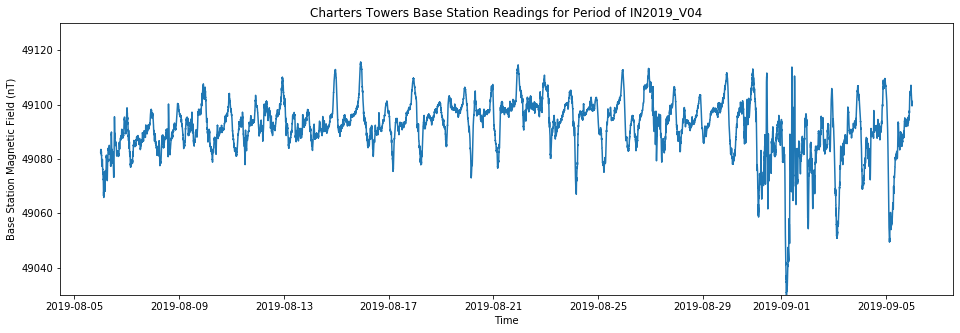

In [19]:
# Assign a time index to the base station data frame
df_base_station['timeindex'] = pd.to_datetime(df_base_station['yyyy-MM-dd HH:mm:ss'])
df_base_station = df_base_station.set_index('timeindex')

df_base_station_1S = df_base_station.resample('1S').interpolate()

plt.figure(figsize=(16,5))
plt.plot(df_base_station['  F (nT)'])
plt.ylim(49080-50,49080+50)
#plt.xlim(pd.Timestamp('2019-08-07'), pd.Timestamp('2019-08-08'))
plt.xlabel('Time')
plt.ylabel('Base Station Magnetic Field (nT)')
plt.title('Charters Towers Base Station Readings for Period of IN2019_V04')
plt.savefig('in2018_v04_base_station.png')

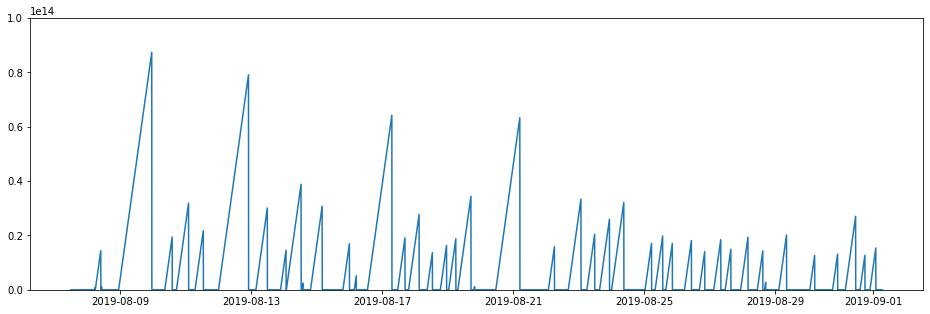

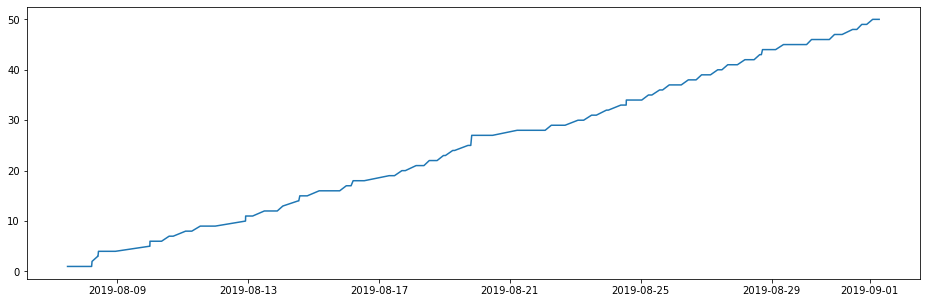

In [15]:
# plot the difference between the time stamp for each succesive pair of rows. 
# Where this is bigger than a second, there is a jump in the data (ie where the magnetometer stopped recording).
plt.figure(figsize=(16,5))
plt.plot(df.index.to_series().diff())
plt.ylim(0,1e14)

# Here we actually use 1 minute as the cutoff to start a new segment
# Then iterate through every row, assign each row the segment number and 
# increment this number by one if we detect a time gap in the data series
time_diff = df.index.to_series().diff()
segment_breaks = time_diff>datetime.timedelta(minutes=1)

segment_numbers = []
counter = 1
for segment_break in segment_breaks:
    if segment_break:
        counter+=1
    segment_numbers.append(counter)
    
# add the segment numbers to the dataframe
df['segment_numbers'] = segment_numbers

# plot the segment numbers versus time
plt.figure(figsize=(16,5))
plt.plot(df.segment_numbers)


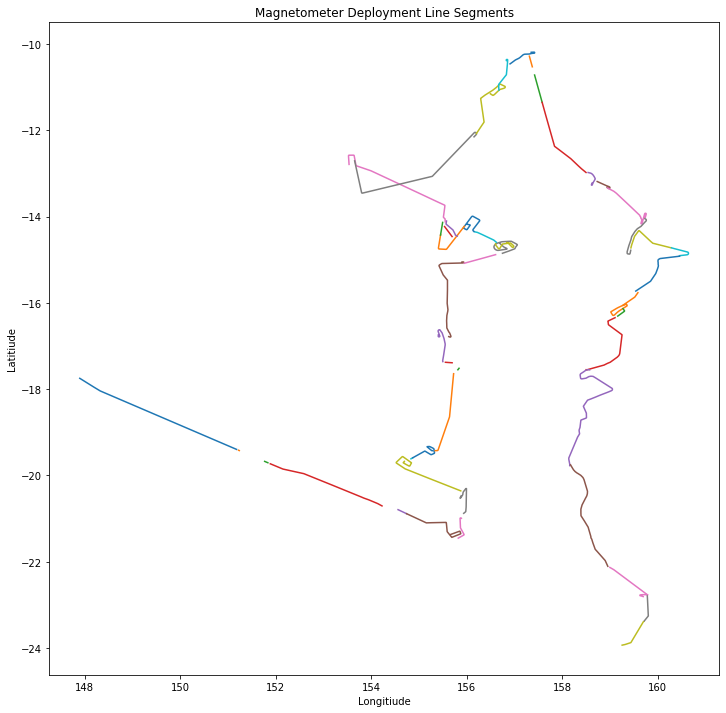

In [18]:
# Plot the segments with different colors to make sure they look sensible

plt.figure(figsize=(12,12))
for segment in np.arange(1,df.segment_numbers.max()):

    subset = df[df.segment_numbers==segment]
    
    plt.plot(subset.Mag_Longitude,subset.Mag_Latitude)

plt.xlabel('Longitiude')
plt.ylabel('Latitiude')
plt.title('Magnetometer Deployment Line Segments')
plt.savefig('in2018_v04_Magnetometer_Segments.png')
plt.show()


In [20]:
# define a function to compute distance (in meters) between points specified as Long-Lat coordinates
def ll2dist(lon,lat):
    earth_radius = 6378137
    lat = lat * np.pi/180
    dlon = (lon[1:] - lon[:-1])*np.pi/180
    dlat = (lat[1:] - lat[:-1])

    a = (np.sin(dlat/2))**2 + np.cos(lat[:-1]) * np.cos(lat[1:]) * (np.sin(dlon/2))**2
    angles = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) )
    return earth_radius * angles


# Here, manually define some masks based on time ranges
# These masks were designed by first plotting each segment without any masking 
# then visually identifying sections that appear problematic
# typically these are at the start or end of a segment, where the ship velocity is slow 
# and the magnetometer readings could be contaminated by the instrument being too close to the ship
# (normally the logging was stopped before this happens, but there may be exceptions)
QCmasks = []
QCmasks.append(('2019-08-07 11:00:00','2019-08-07 12:00:00'))
QCmasks.append(('2019-08-10 08:30:00','2019-08-10 09:00:00'))
QCmasks.append(('2019-08-10 17:00:00','2019-08-10 17:20:00'))
QCmasks.append(('2019-08-11 06:40:00','2019-08-11 07:00:00'))
QCmasks.append(('2019-08-11 23:45:00','2019-08-12 00:00:00'))
QCmasks.append(('2019-08-13 03:18:00','2019-08-13 04:00:00'))
QCmasks.append(('2019-08-26 16:30:00','2019-08-26 17:00:00'))
QCmasks.append(('2019-08-28 05:52:20','2019-08-28 05:52:40'))


print(df.segment_numbers.max())

# empty list to place the QC'ed segment dataframes
df_QC_list = []


# loop over each segment, create a subset dataframe and apply QC to this
for segment in np.arange(1,df.segment_numbers.max()):

    subset = df[df.segment_numbers==segment]
    subset_QC = subset.copy()

    # Set values where signal strength is not good to NaN
    subset_QC['igrf_corrected_mag'][subset_QC.Signal_Quality < 99] = np.nan
    
    # Set values within the manually defined time masks to NaN
    for QCmask in QCmasks:
        subset_QC[QCmask[0]:QCmask[1]]['igrf_corrected_mag'] = np.nan
        
    #subset_QC = subset_QC.dropna(subset=['igrf_corrected_mag'])
    
    # Interpolate data gaps - note that no extrapolation is done at data edges, only filling holes
    subset_QC['igrf_corrected_mag'] = subset_QC['igrf_corrected_mag'].interpolate(limit_area='inside')
    
    
    # For plotting, derive the ship velocity from Location coordinates
    distance_delta = ll2dist(np.asarray(subset.Mag_Longitude),np.asarray(subset.Mag_Latitude))
    time_diff = subset.index.to_series().diff()
    velocity = distance_delta[1:]/time_diff.dt.seconds[1:-1]

    # Create plot for the segment
    plt.figure(figsize=(16,10))
    plt.subplot(311)
    plt.plot(subset.index[1:-1],velocity)
    plt.ylabel('Derived Velocity (m/s)')
    #plt.xlim(pd.Timestamp('2019-08-28 05:52:00'), pd.Timestamp('2019-08-28 05:53:00'))

    plt.subplot(312)
    plt.plot(subset.Signal_Quality[1:])
    plt.ylabel('Signal Quality')
    #plt.xlim(pd.Timestamp('2019-08-28 05:52:00'), pd.Timestamp('2019-08-28 05:53:00'))
    
    plt.subplot(313)
    plt.plot(subset.igrf_corrected_mag[1:])
    plt.plot(subset_QC.igrf_corrected_mag[1:],'r')
    plt.ylabel('IGRF corrected Magnetic Anomaly (nT)')
    #plt.xlim(pd.Timestamp('2019-08-28 05:52:00'), pd.Timestamp('2019-08-28 05:53:00'))
    
    plt.savefig('./QCPlot_segment%d.pdf' % segment)
    plt.close()
    
    # here we would also reject segments that are spuriously short (less than 100 seconds)
    if len(subset_QC)>100:
        df_QC_list.append(subset_QC)



50


/Users/simon/anaconda2/envs/stagpy/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/simon/anaconda2/envs/stagpy/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/simon/anaconda2/envs/stagpy/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/simon/anaconda2/envs/stagpy

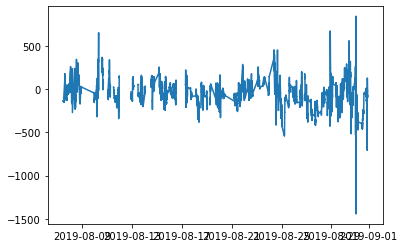

In [319]:
df_QC = pd.concat(df_QC_list)

plt.plot(df_QC.igrf_corrected_mag)


In [360]:
# define a function to create wiggle plots, assuming that gmt is available
def make_wiggle_plot(region,proj,filename):
    os.system('gmt makecpt -Cpolar -T-200/200/10 -D > emag2.cpt')
    os.system('gmt makecpt -Cgray -T-5000/0/200 -D > bathym.cpt')
    #os.system('gmt grdimage /Users/simon/Data/StefanMausData/EMAG2_V3/EMAG2_V3_UpCont_Data.nc %s -Cemag2.cpt -Jm2.0i -K > wiggle_plot.ps' % region)
    os.system('gmt grdimage /Users/simon/Data/GMTdata/VGG22/topo19.1_ECOSAT3.nc %s -Cbathym.cpt %s -K > %s.ps' % (region,proj,filename))
    os.system('gmt pswiggle wiggle_plot_input.xyz %s %s -O -Ba1f0.2 -G+red -G-blue -Z500 -T0.25p,white -Wthinnest -S159.5/-19/500/nT --FORMAT_GEO_MAP=dddF >> %s.ps' % (region,proj,filename))
    os.system('gmt psconvert %s.ps -A0.25c -E600 -Tg -P -Z' % filename)

    
df_wiggle = df_QC.dropna(subset=['igrf_corrected_mag'])[::10]
df_wiggle.to_csv('wiggle_plot_input.xyz',columns=['Mag_Longitude','Mag_Latitude','igrf_corrected_mag'],index=False)

In [338]:
region = '-R157/160/-19.5/-16.5'
filename = 'wiggle_plot_horsehead'
proj = '-Jm2.0i'

make_wiggle_plot(region,proj,filename)


In [339]:
region = '-R153/159.25/-16/-9.5'
filename = 'wiggle_plot_louisiade'
proj = '-Jm1.0i'

make_wiggle_plot(region,proj,filename)


In [340]:
region = '-R157.5/161.5/-18.5/-13.5'
filename = 'wiggle_plot_SouthRennellTrough'
proj = '-Jm1.0i' 

make_wiggle_plot(region,proj,filename)


In [345]:
region = '-R157.5/161.5/-25/-18'
filename = 'wiggle_plot_LordHoweTrail'
proj = '-Jm0.8i'

make_wiggle_plot(region,proj,filename)

In [351]:
region = '-R153.5/157.5/-22/-14'
filename = 'wiggle_plot_TasmantidTrail'
proj = '-Jm0.6i'

make_wiggle_plot(region,proj,filename)


In [354]:
region = '-R156/157.5/-15.5/-14'
filename = 'wiggle_plot_Lexington'
proj = '-Jm3.0i'

make_wiggle_plot(region,proj,filename)

In [365]:
region = '-R158.5/160.2/-23.2/-21.5'
filename = 'wiggle_plot_Nova'
proj = '-Jm3.0i'

make_wiggle_plot(region,proj,filename)

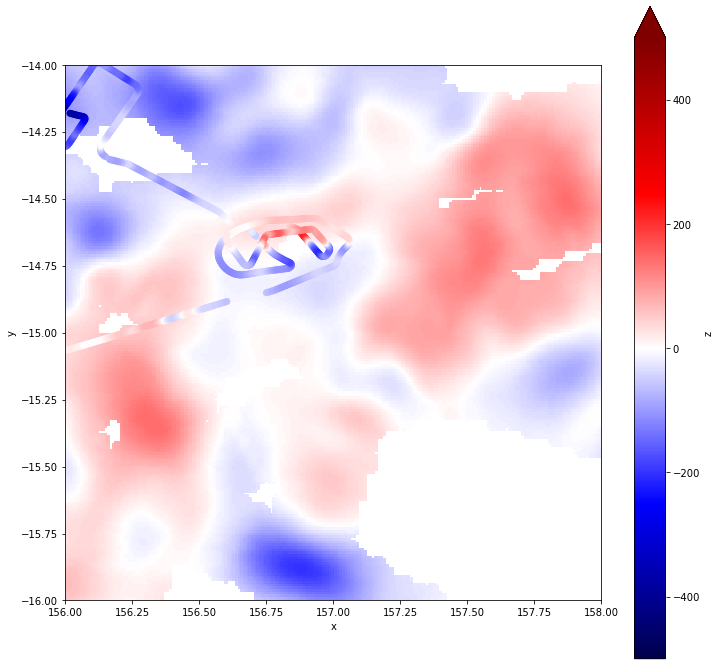

In [23]:
plt.figure(figsize=(12,12))
ds['z'].plot(vmin=-500,vmax=500,cmap=plt.cm.seismic)
plt.scatter(df.Mag_Longitude[::10],df.Mag_Latitude[::10],c=df.igrf_corrected_mag[::10],
            vmin=-500,vmax=500,cmap=plt.cm.seismic)

#plt.xlim(158.5,160.2)
#plt.ylim(-23.2,-21.5)
plt.xlim(156,158)
plt.ylim(-16,-14)

plt.gca().set_aspect('equal')
